<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Simple-first-run" data-toc-modified-id="Simple-first-run-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Simple first run</a></span></li><li><span><a href="#Use-pytorch-convolution" data-toc-modified-id="Use-pytorch-convolution-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Use pytorch convolution</a></span></li><li><span><a href="#Save-data-for-later-analysis-and-plotting" data-toc-modified-id="Save-data-for-later-analysis-and-plotting-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Save data for later analysis and plotting</a></span></li><li><span><a href="#Use-simple-serial-algorithm" data-toc-modified-id="Use-simple-serial-algorithm-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Use simple serial algorithm</a></span></li></ul></div>

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scripts import ising
from scripts import torch_ising
from multiprocessing import Pool

%load_ext autoreload
%autoreload 2

# Insight from using full energy
np.seterr(over='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Simple first run

1. Iniatilize NxN grid
2. Compute the initial energy $E$
3. Flip random spin and compute $\Delta E$
4. Accept or reject based on criteria
5. Continue to 3

In [2]:
#@profile
def random_ix(N, steps):
    randix = (np.random.randint(0, N, size=(steps,2)))
    return randix

In [39]:
N = 60
grid = ising.get_random_grid(N)

## Use pytorch convolution

In [33]:
def simulate_torch(T,grid, J,mu,N, therm_sweeps=1500, measure_sweeps=800):
    beta = 1/T

    # Thermalise    
    mask = torch_ising.get_anisotropic_mask(J, mu, 0.98)
    #mask = torch_ising.get_diagonal_mask(J, mu)
    conv = torch_ising.get_conv_torch(mask)
    
    for ix in range(9*therm_sweeps):
        grid, dE, dM = torch_ising.metrop_step(grid, conv, beta)
    
    E = [ising.ising_energy(grid[0][0], J, mu).cpu().numpy()]
    M = [grid.sum().cpu().numpy()]
    #grid = grid.cpu().numpy()[0,0]
    for ix in range(9*measure_sweeps):
        #dE = ising.metrop_step(grid, ix, J, mu, beta, N)
        grid, dE, dM = torch_ising.metrop_step(grid, conv, beta)
        dE = dE or 0
        E.append( E[-1] + dE )
        M.append( M[-1] + dM )
    return E, M, grid

def simulate_torch_seq(temps, grid, J, mu, N, therm_sweeps=1500, measure_sweeps=800):
    em = []
    grids = []
    for T in tqdm(temps):
        a= (T, grid, J,mu,N, therm_sweeps, measure_sweeps)
        E, M, grid = simulate_torch(*a)
        grids.append(grid)
        em.append((E,M))
    return em, grids

In [40]:
J = 0.5
mu = 0.

temps = np.linspace(0.05, 3, 15)
temps = np.concatenate((temps, np.linspace(0.45, 1.3, 30)))
temps = np.concatenate((temps, np.linspace(0.5, 0.8 , 10)))
temps = np.sort(temps)

grid = torch_ising.get_random_grid(N, device='cpu')
pool = Pool(processes=2)
therm_sweeps = 2500
measure_sweeps = 1200

args = [(T, grid, J,mu,N,therm_sweeps, measure_sweeps) for T in temps]
# To run in parallel, use s-tarmap
#ems = pool.starmap(simulate_torch, args)
ems, grids = simulate_torch_seq(temps, grid, J, mu, N, therm_sweeps, measure_sweeps)
eneg_tm, mag_tm = zip(*ems)

100%|██████████| 55/55 [15:27<00:00, 16.87s/it]


In [72]:
# Clear tqdm
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

## Save data for later analysis and plotting

In [41]:
energies = np.mean(eneg_tm, axis=1)
heat = np.std(eneg_tm, axis=1)
magnetizations = np.mean(mag_tm, axis=1)
susc = np.std(mag_tm, axis=1)
an = .95
R = (1+an)/(1-an)

exp = {
    'N':N
    ,'J':J
    ,'mu':mu
    ,'therm_sweeps':therm_sweeps
    ,'measure_sweeps':measure_sweeps
    ,'temps': temps
    ,'energies':energies
    ,'magn':magnetizations
    ,'heat':heat
    ,'susc':susc
    
    ,'an':an
    
}

fn = f'../data/exp_N{N}_sweep{therm_sweeps}_mu{mu}_temp2_anisotr.98'
print(fn)
np.save(fn, exp)

../data/exp_N60_sweep2500_mu0.0_temp2_anisotr.98


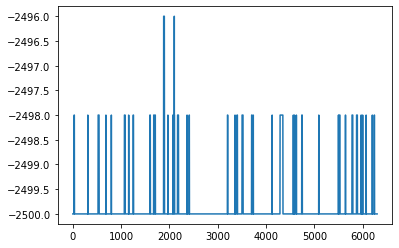

In [30]:
plt.plot(mag_tm[20])

In [ ]:
# smoothing
plt.plot(np.convolve(energies, np.ones((N**2,))/N**2, mode='valid'))

In [164]:
n_ = 10
an = .95
R = (1+an)/(1-an)
plt.title(f'J\'/J={R:.4} T={temps[n_]:.2}')
plt.imshow(grids[n_][0,0])

In [137]:
plt.savefig(f'../data/figures/Grid_anisotropy{an}_T.52.png')

<Figure size 432x288 with 0 Axes>

In [ ]:
#grid = get_random_grid(50)
mask = torch_ising.get_anisotropic_mask(J, mu, 0.5)
plt.imshow(mask, colormap='grayscale')

## Use simple serial algorithm

In [ ]:
J = 0.5
mu = 0

temps = np.linspace(0.05, 3, 100)
eneg_tm = []
mag_tm = []
for T in temps:
    beta = 1/T
    grid = ising.get_random_grid(N)
    
    # Thermalise    
    therm_sweeps = 200
    for ix in random_ix(N, steps=N**2*therm_sweeps):
        dE = ising.metrop_step(grid, ix, J, mu, beta, N)
    
    E = [ising.ising_energy(grid, J, mu)]
    M = [np.mean(grid)]
    print('measure t=',T)
    for ix in random_ix(N, steps=N**2*100):
        raise
        dE = ising.metrop_step(grid, ix, J, mu, beta, N)
        dE = dE or 0
        E.append( E[-1] + dE )
        M.append(np.mean(grid))
        
    print('done measure')
    eneg_tm.append(E)
    mag_tm.append(M)

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(8,6))

[ax.set_title(t) for ax, t in zip(sum(map(list, axs),[]),
                              ['Energy','Specific Heat', 'Magnetization', 'Susceptibility'])]

axs[0,0].plot(temps, list(map(np.mean, eneg_tm)))
axs[0,1].plot(temps, list(map(np.std, eneg_tm)))
axs[1,0].plot(temps, list(map(np.mean, mag_tm)))
axs[1,1].plot(temps, list(map(np.std, mag_tm)))
